# Bulldozers with Random forests
Predicting sale price for heavy equipment

## Goals:
- feature selection, engineering, cleaning
    - handling null values, dates, categories
- proper dataset splitting
- model interpretation
    - plotting individual tree, feature importances, treeinterpreter, ...

### Problem with RF and temporal dependent variable:
The nature of tree splits kind of limits the extrapolation in the test set, which will be in the future, whereas in e.g. a linear model the extrapolation is much more natural.

Courtesy of https://github.com/fastai/fastai/blob/master/courses/ml1/lesson2-rf_interpretation.ipynb

## 1. Initial cleanup and getting a baseline score

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
PATH = "data\\bulldozers\\"

In [88]:
from ml_helpers.imports import *
from ml_helpers.df import *
from ml_helpers.engineering import *
from ml_helpers.manipulation import *
from ml_helpers.visualization import *
from ml_helpers.rf import *
from ml_helpers.score import rmse

In [4]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, parse_dates=["saledate"])

Split dependent variable from independent variables and change the df into numeric dataframe. 

In [5]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [6]:
df_trn, y_trn = basic_preprocess_df(df_raw, 'SalePrice', datepart='saledate')

I'll make use of both numericalized data and raw data for additional exploration and plotting

In [7]:
display_all(find_nans(df_raw)[:5])

Engine_Horsepower    0.937129
Pushblock            0.937129
Blade_Extension      0.937129
Tip_Control          0.937129
Blade_Width          0.937129
dtype: float64

In [8]:
display_all(find_nans(df_trn)[:5])

state                       0.0
MachineHoursCurrentMeter    0.0
Steering_Controls           0.0
Scarifier                   0.0
SalesID                     0.0
dtype: float64

In [9]:
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_dataset(df_trn, n_trn)
y_train, y_valid = split_dataset(y_trn, n_trn)
raw_train, raw_valid = split_dataset(df_raw, n_trn)

Note: Data is not shuffled on purpose - this dataset has a time element = the test set provided by kaggle has all dates later (we're trying to predict prices in the future) - we want to kind of replicate this with our validation dataset, so randomly shuffling it would make it easier and will lead to inaccurate predictions.

### What metric to use?
Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.
- we need to transform SalePrice to log scale

### Fitting the RF model
Sklearn's random forest can only work with numerical values. We need to do some feature engineering:
- transform strings to categorical variables (- should they be ordinal?)
- transform dates into meaningful set of features
- deal with NaNs - fill with mean value, introduce boolean _na column

### RandomForest parameters
- min_samples_leaf=3 - stop training the tree when my leaf node has 3 or less samples in them
- max_features=0.5 - the less correlated trees, the better. At every single split point, take different columns. This number specifies the proportion of features randomly selected for each split

Display missing columns

In [10]:
from sklearn.ensemble import RandomForestRegressor
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
          m.score(X_train, y_train), m.score(X_valid, y_valid)]
    return res

m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

C:\Users\terez\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 37.4 s


[0.09076577528399934,
 0.25370353684469354,
 0.9827821440827794,
 0.8850521063783855]

## 2. Feature Exploration using Tree variance

#### Validation without validation set - OOB (Out-of-bag) score
Not all the rows are used in training a specific tree. Idea: How each row, calculate its error on a tree that didn't use that row in training.

#### Subsampling - reduce overfitting and speed up the computation
There are a lot of rows so .fit() takes a long time. I don't want to just take a portion of training dataset: let's instead limit our model to a different random subset per tree. 
- realistically, some datasets are so big there's no way i'd fit a RF to them
- there's not an easy way to do it, sklearn's API has to be played with, encapsulated in a function

In [11]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
set_rf_samples(50000)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(df_trn, y_trn)
display(print_score(m))
m.oob_score_

[0.20643045915023495,
 0.21497071140445898,
 0.9109400630842445,
 0.9174710040817802]

0.8946610658423825

In [12]:
%time rf_mean, rf_std = tree_variances(m, X_valid)
rf_mean, rf_std

Wall time: 1.91 s


(10.016043307875826, 0.7269932511451356)

Add the tree predictions and stddevs into the validation set and explore relationships of different features with the dependent variable

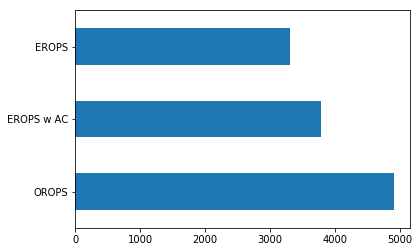

In [13]:
x = raw_valid.copy()
x['pred_std'] = rf_std
x['pred'] = rf_mean
x.Enclosure.value_counts().plot.barh();

,UsageBand,SalePrice,pred,pred_std
0,High,10.006126,10.016043,0.726993
1,Low,9.505382,10.016043,0.726993
2,Medium,9.705702,10.016043,0.726993


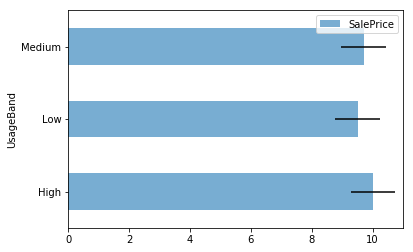

In [14]:
def feature_against_target(feature):
    flds = [feature, 'SalePrice', 'pred', 'pred_std']
    enc_summ = x[flds].groupby(feature, as_index=False).mean()
    display(enc_summ)
    enc_summ.plot(feature, 'SalePrice', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

feature_against_target('UsageBand')

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,10.016043,0.726993
1,EROPS w AC,10.623971,10.016043,0.726993
2,OROPS,9.682064,10.016043,0.726993


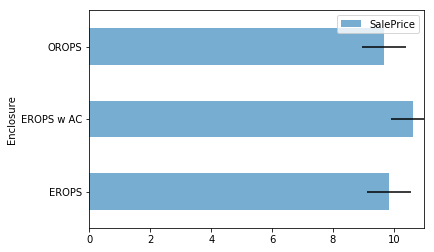

In [15]:
feature_against_target('Enclosure')

,ProductSize,SalePrice,pred,pred_std
0,Compact,9.735093,10.016043,0.726993
1,Large,10.470589,10.016043,0.726993
2,Large / Medium,10.691871,10.016043,0.726993
3,Medium,10.681511,10.016043,0.726993
4,Mini,9.535147,10.016043,0.726993
5,Small,10.324448,10.016043,0.726993


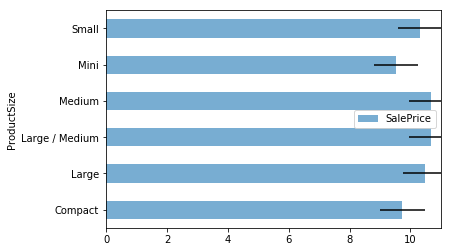

In [16]:
feature_against_target('ProductSize')

Get a better understanding about what's going on using just a single tree

In [17]:
tree = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
%time tree.fit(X_train, y_train)
print_score(tree)

Wall time: 3.44 s


[0.5371269683343529,
 0.5674541015387069,
 0.3970396664995464,
 0.4249449087372361]

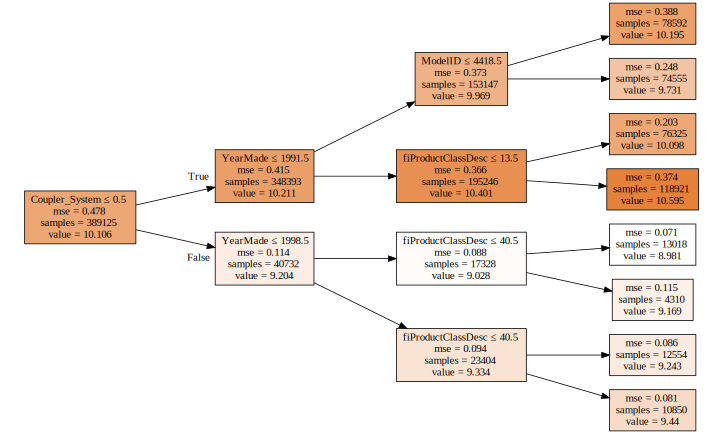

In [18]:
draw_tree(tree.estimators_[0], X_train, precision=3)

Predictions are made by taking the average value in each leaf node in each tree after running a particular row through each tree. We want to know how confident we are. Typically we're not confident in the rows we didn't see much examples of the row in the training data. This should be demontrated in big deviation among the individual estimators in the RF

Check out the decision of individual trees, their average and how does it compare to the prediction.

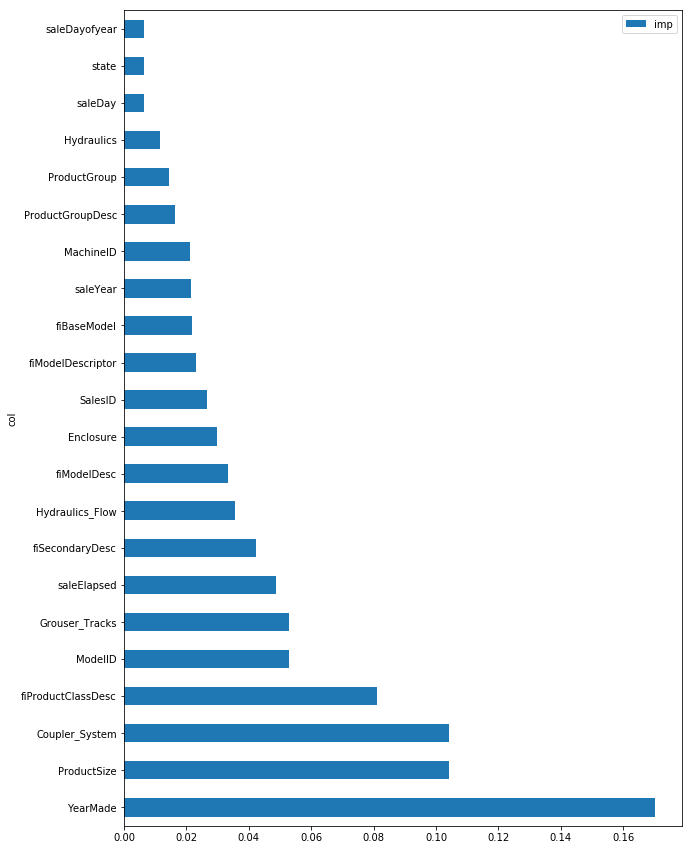

In [19]:
fi = create_fi_df(df_trn, m)
fi[fi['imp'] > 0.005].plot('col', 'imp', 'barh', figsize=(10,15))

### Let's try to explore feature importances again with just a subset of the features

In [20]:
features_to_keep = fi[fi.imp>0.005].col; len(features_to_keep)

22

[0.20811518321274933, 0.246552079797479, 0.909480456011314, 0.8914411298250698]

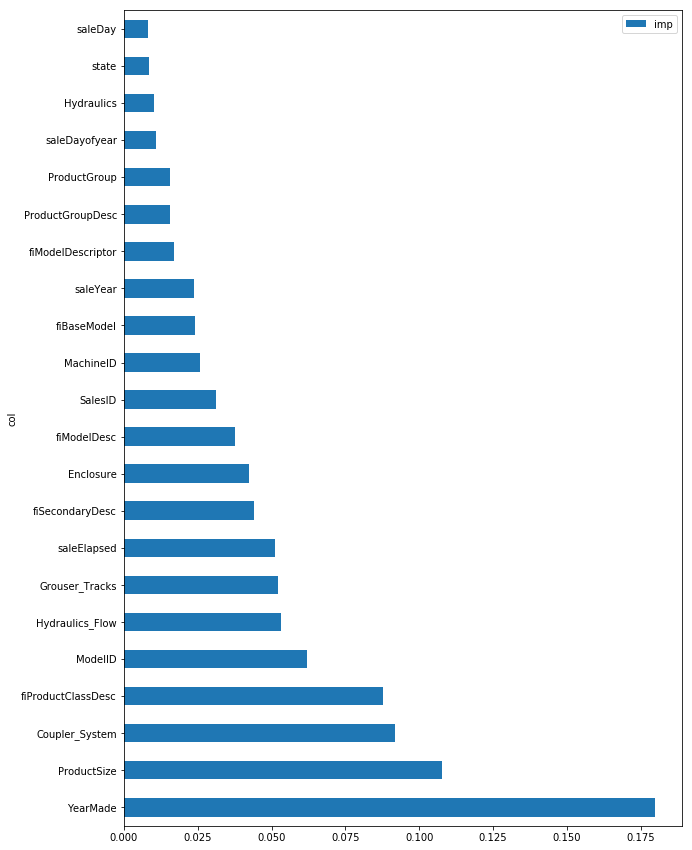

In [21]:
df_keep = df_trn[features_to_keep].copy()
X_train, X_valid = split_dataset(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
display(print_score(m))

fi = create_fi_df(df_keep, m)
fi.plot('col', 'imp', 'barh', figsize=(10,15))

### Let's try to explore feature importances again with some additional columns using one-hot-encoding

In [22]:
df_trn2, y_trn = basic_preprocess_df(df_raw, 'SalePrice', max_n_cat=7, datepart='saledate')

In [23]:
X_train, X_valid = split_dataset(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2067918699843392,
 0.25223738110088845,
 0.9106279443947571,
 0.8863768379430508]

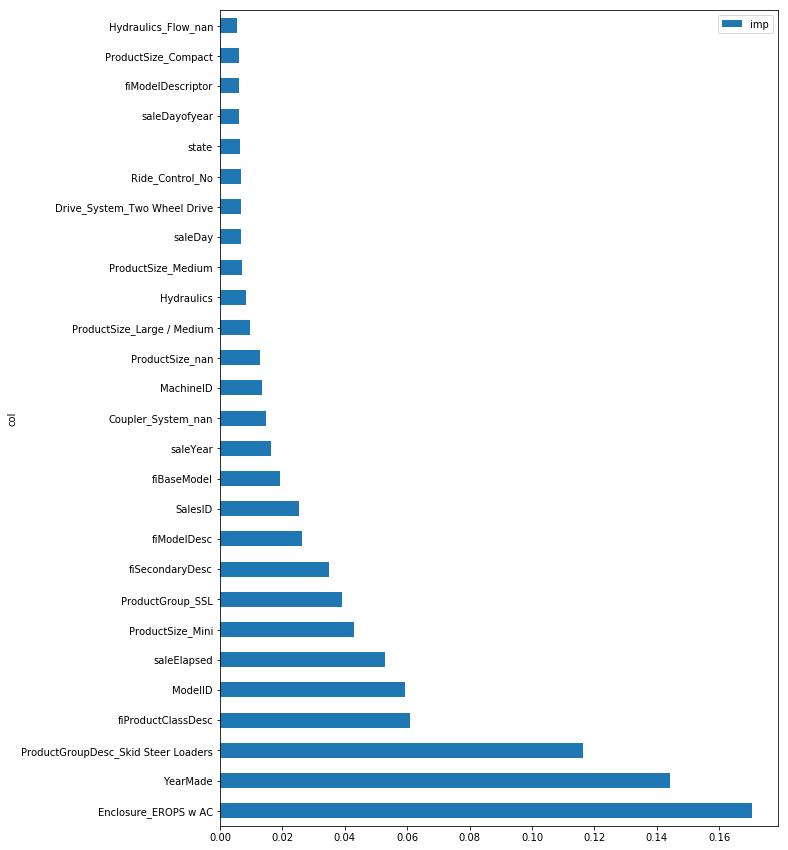

In [24]:
fi = create_fi_df(df_trn2, m)
fi[fi['imp'] > 0.005].plot('col', 'imp', 'barh', figsize=(10,15))

Enclosure_EROPS w/ AC seems to be important, i'll explore it later, let's see that features i can get rid of.

## Removing redundant features
- plot the features via horizontal dendrogram
- use oob as a baseline i don't want to go below

In [26]:
import scipy

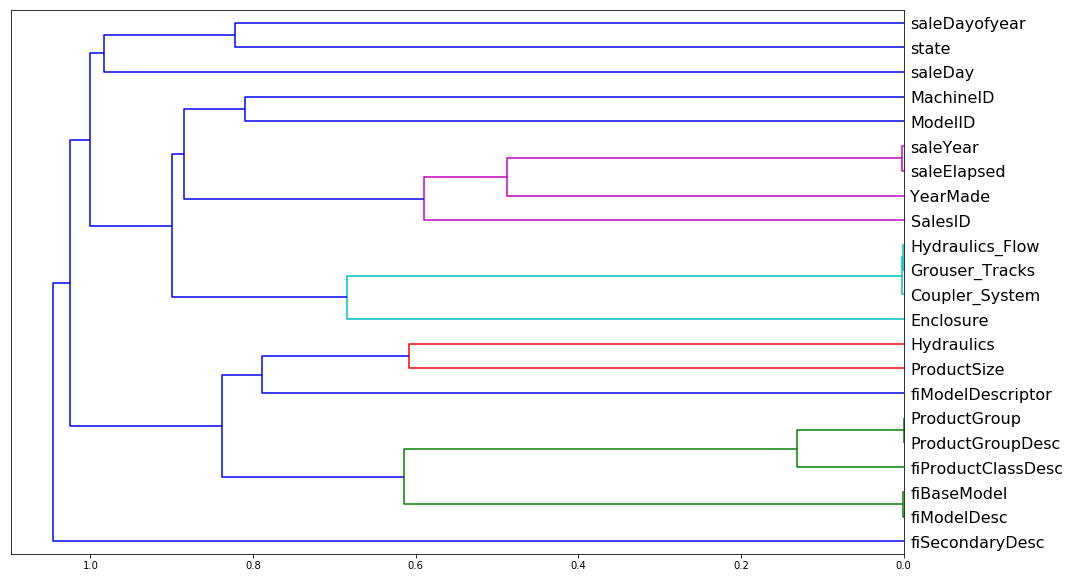

In [27]:
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [33]:
def get_oob(df):
    """ Fits a rf and returns oob_score. Suitable for finding a baseline, e.g. in feature removal

        for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
                print(c, get_oob(df_keep.drop(c, axis=1), n_trn))
    """
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_dataset(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [34]:
get_oob(df_keep)

0.8886643256188993

In [35]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8878011748389227
saleElapsed 0.8860902610505355
fiModelDesc 0.8876162207079379
fiBaseModel 0.8881992598017009
Grouser_Tracks 0.8884953838527192
Coupler_System 0.889242868846021


In [36]:
df_keep.drop(['Coupler_System'], axis=1, inplace=True)

In [37]:
reset_rf_samples()

In [38]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1199949663295128,
 0.23397384789969197,
 0.9699073189226499,
 0.9022351791206942]

## Partial dependence

In [40]:
from pdpbox import pdp
from plotnine import *

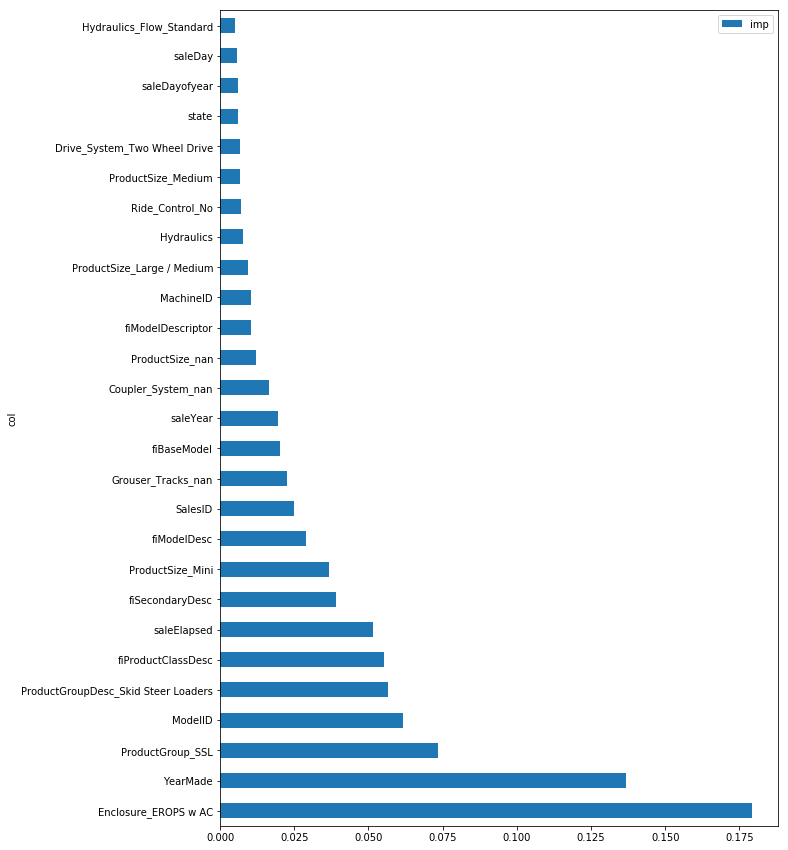

In [44]:
fi = create_fi_df(df_trn2, m)
fi[fi['imp'] > 0.005].plot('col', 'imp', 'barh', figsize=(10,15))

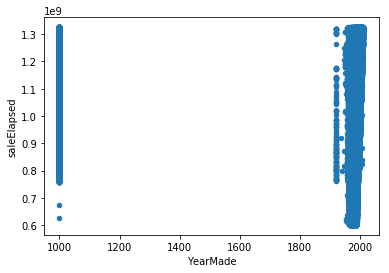

In [50]:
df_proc = df_trn2.copy()
df_proc['SalePrice'] = y_trn
df_proc.plot('YearMade', 'saleElapsed', 'scatter')

In [54]:
x_all = get_random_df_sample(df_raw[df_raw.YearMade>1930], 500)

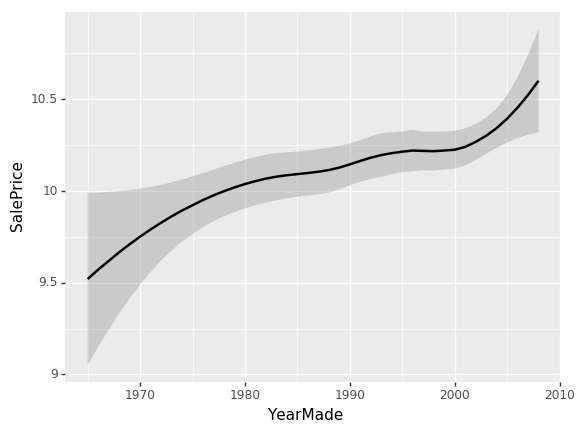

<ggplot: (-9223371894666247778)>

In [56]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [72]:
x_all = get_random_df_sample(X_train[df_raw.YearMade>1930], 500)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x211b1893080>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x211b2358240>})

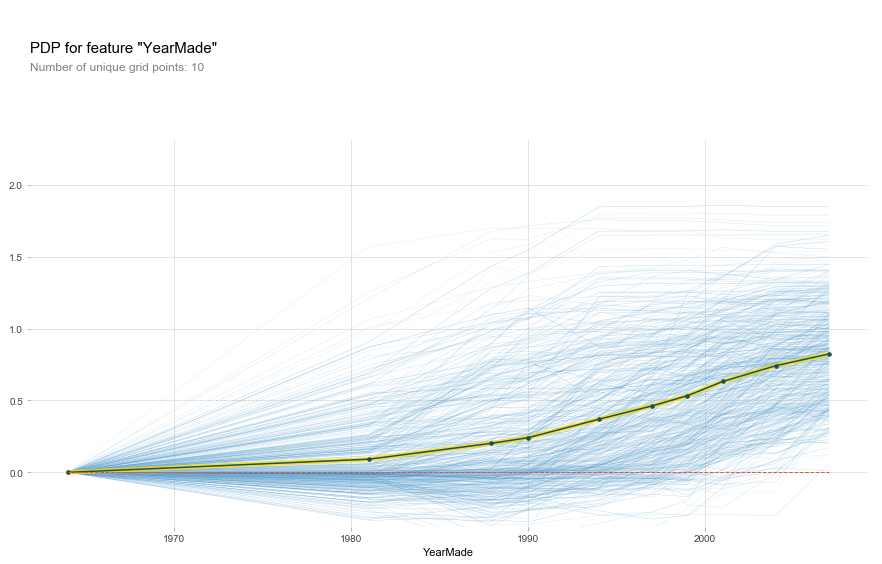

In [73]:
def plot_pdp(feat_name, clusters=None):
    p = pdp.pdp_isolate(m, x_all, feature=feat_name, model_features=x_all.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)
plot_pdp('YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x211b2f06828>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x211b2ececf8>})

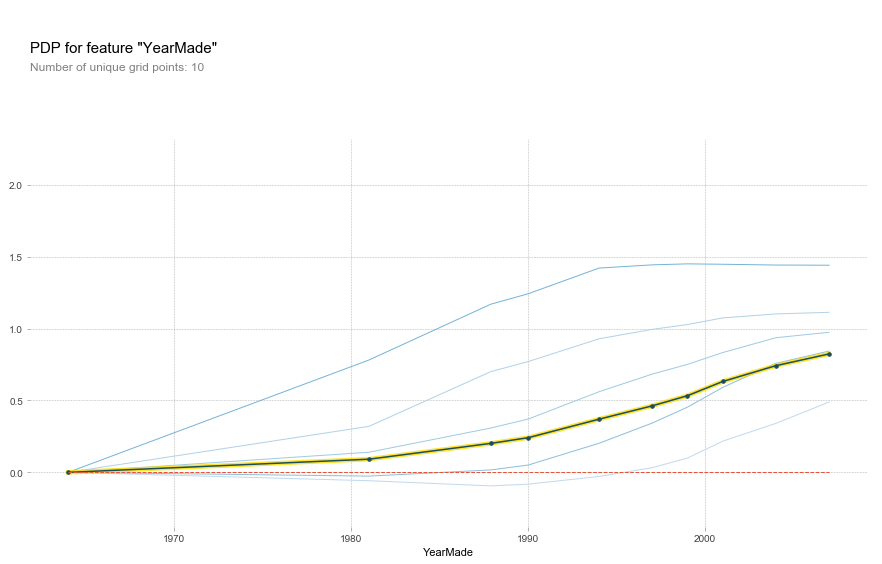

In [74]:
plot_pdp('YearMade', clusters=5)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x211b2f5c080>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x211b2f41a90>})

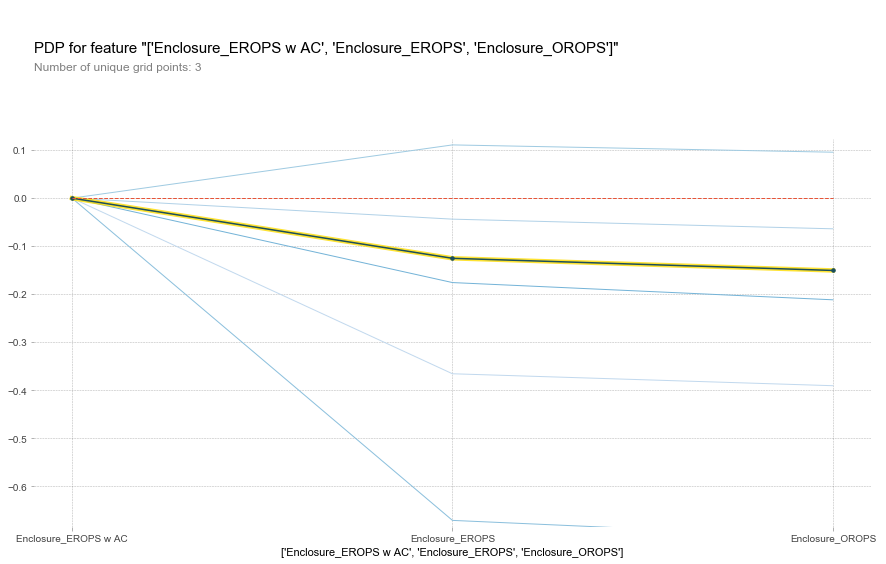

In [77]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5)

In [79]:
df_trn.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_trn['age'] = df_trn.saleYear-df_trn.YearMade

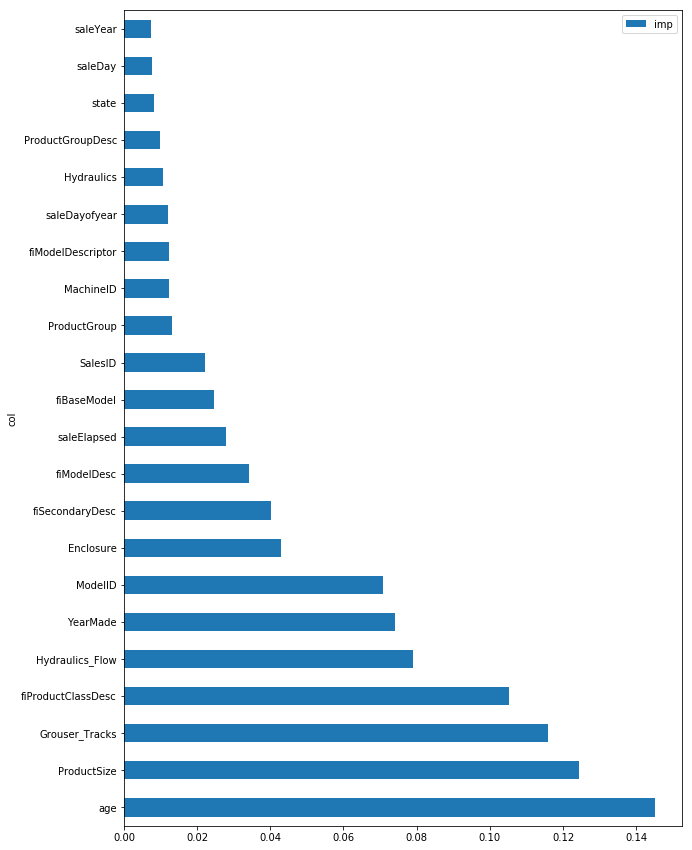

In [80]:
X_train, X_valid = split_dataset(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
fi = create_fi_df(df_keep, m)
fi[fi['imp'] > 0.005].plot('col', 'imp', 'barh', figsize=(10,15))

## Tree interpreter
- for a specific row shows the contribution of each feature to its prediction

In [93]:
df_train, df_valid = split_dataset(df_keep[df_keep.columns], n_trn)
row = X_valid.values[None,0]; row

array([[      1999,          5,         17,        665,          0,
        1284595200,          0,          0,       3232,          1,
           4364751,          0,       1111,       2010,    2300944,
                 4,          4,         12,         16,         35,
               259,         11]], dtype=int64)

In [94]:
prediction, bias, contributions, imps = tree_imps(m, row, df_train, df_valid)

In [95]:
imps

[('ProductSize', 5, -0.6031382983103194),
 ('age', 11, -0.18642686346961374),
 ('fiProductClassDesc', 17, -0.10673516378627727),
 ('fiSecondaryDesc', 0, -0.09680693570532344),
 ('fiModelDesc', 3232, -0.07640483617586251),
 ('fiBaseModel', 1111, -0.05237667780114541),
 ('saleElapsed', 1284595200, -0.026626898144624357),
 ('Enclosure', 1, -0.0185309025675676),
 ('saleYear', 2010, -0.016133718922103978),
 ('fiModelDescriptor', 0, -0.014408723223942977),
 ('saleDayofyear', 259, -0.01353794270257298),
 ('Hydraulics', 12, -0.004798917856741447),
 ('saleDay', 16, 0.0032416454970447097),
 ('ProductGroup', 4, 0.003917488357095378),
 ('SalesID', 4364751, 0.0039687723017810764),
 ('state', 35, 0.005415815699965787),
 ('ProductGroupDesc', 4, 0.01158573936669689),
 ('MachineID', 2300944, 0.017608823557200903),
 ('Hydraulics_Flow', 0, 0.03680902791008189),
 ('Grouser_Tracks', 0, 0.05786017094631535),
 ('ModelID', 665, 0.07585391711234686),
 ('YearMade', 1999, 0.07677461788160453)]

Explanation:
- small `ProductSize` means less expensive (against dep. var, so `SalePrice`)
- made pretty recently (large-ish `YearMade`) means more expensive

Helps in intuitive explanation of what's the model doing in production environment: E.g. situation: "Explain why your model is predicting x when i think if should've predicted y"

## Extrapolation
What is the difference between our training and validation set?
- what are the predictors that have strong temporal component and therefore they may be irrelevant by the time i get to the future time period?

### Goal:
Have training and validation set as time-independent as possible to get a model that generalizes better over time.

In [96]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x,y = basic_preprocess_df(df_ext, 'is_valid')

Predicting: is this in a validation set or not?

If the variables are not time-dependent, it shouldn't be possible to predict whether something is in the validation set or not.

In [98]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y)
m.oob_score_

0.999937035574973

In [100]:
fi = create_fi_df(x, m); fi[:10]

,col,imp
10,SalesID,0.798204
5,saleElapsed,0.118103
13,saleYear,0.046745
14,MachineID,0.028644
20,saleDayofyear,0.005671
12,fiBaseModel,0.001055
3,ModelID,0.000702
9,Enclosure,0.000237
17,Hydraulics,0.000206
18,saleDay,0.000097


Explanation:
- `SalesID` is probably something that increases consecutively
- ...

Grab the top 4, look at them in the training/validation sets:

Explore the differences between training and validation sets in terms of these predictive features

In [103]:
feats = ['SalesID', 'saleElapsed', 'saleYear', 'MachineID']
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,saleYear,MachineID
count,389125.000000,3.891250e+05,389125.000000,389125.000000
mean,1800.452485,1.084797e+06,2.003892,1206.796148
std,595.627288,1.803913e+05,0.005721,430.850552
min,1139.246000,6.009984e+05,1.989000,0.000000
25%,1413.348000,9.666432e+05,2.000000,1087.016000
50%,1632.093000,1.134605e+06,2.005000,1273.859000
75%,2210.453000,1.234138e+06,2.009000,1458.661000
max,4364.741000,1.325117e+06,2.011000,2313.821000


In [104]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,saleYear,MachineID
count,12000.000000,1.200000e+04,12000.000000,12000.000000
mean,5786.967651,1.306609e+06,2.010707,1578.049709
std,836.899608,2.497808e+04,0.000667,589.497173
min,4364.751000,1.174522e+06,2.007000,0.830000
25%,4408.580750,1.309219e+06,2.011000,1271.225250
50%,6272.538500,1.316045e+06,2.011000,1825.317000
75%,6291.792250,1.321402e+06,2.011000,1907.858000
max,6333.342000,1.325203e+06,2.011000,2486.330000


Drop them and see if i still can predict whether something's in a validation set or not

In [105]:
x.drop(feats, axis=1, inplace=True)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y)
m.oob_score_

0.5446051075082632

In [106]:
fi = create_fi_df(x, m); fi[:10]

,col,imp
17,age,0.234581
0,YearMade,0.191807
16,saleDayofyear,0.173111
14,saleDay,0.067125
3,ModelID,0.064342
15,state,0.057137
7,fiModelDesc,0.041203
10,fiBaseModel,0.035871
8,Enclosure,0.028958
2,fiProductClassDesc,0.027694


In [108]:
feats = ['SalesID', 'saleElapsed', 'saleYear', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

I can do this time and time again, but let's try to go through all of them - remove them, see how does that impact generalization performance and drop/keep it.

In [109]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_dataset(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f"{f}: {m.oob_score_}")

SalesID: 0.9085110994997951
saleElapsed: 0.9068949598767577
saleYear: 0.9085382078440483
MachineID: 0.9099836285202214
age: 0.9090557081781672
YearMade: 0.9089201889312623
saleDayofyear: 0.9076434597171623


Let's remove the features whose removal helped the generalization a bit.

In [110]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_dataset(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1386004067537964,
 0.21792424678795613,
 0.9598520073739809,
 0.9151876530669433]

In [112]:
fi = create_fi_df(X_train, m); fi[:40]

,col,imp
18,age,0.147618
1,ProductSize,0.124046
2,fiProductClassDesc,0.103534
4,Grouser_Tracks,0.089000
7,Hydraulics_Flow,0.085192
0,YearMade,0.081000
3,ModelID,0.068501
9,Enclosure,0.053344
6,fiSecondaryDesc,0.042737
8,fiModelDesc,0.041872


## Final model

In [113]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
display(print_score(m))
print(f"oob_score: {m.oob_score_}")

Wall time: 2min 50s


[0.08119762106729018,
 0.21034980428209385,
 0.9862208814397533,
 0.9209808782366572]

oob_score: 0.9143181633267194


## Notes:
Interpreting feature importances via a model when it doesn't have a `feature_importances_` accessor (- works for any type of model):
- run prediction on the cleaned/prepared dataset, calculate the score
- randomly shuffle examples within 1 independent variable, run again, calculate again = the difference in accuracies is the feature importance